<h1>
<center>Classifying Credit Card Defaults</center>
</h1>

<h1>
<center>Avery Lee</center>
</h1>

# Default dataset 

For this project we want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features. 

After loading the dataset, let's split the data into a training and a test set, using 20% of the data for the test set. 

In [ ]:
import os
import pandas as pd
data = pd.read_csv("Default.csv")
data

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

data_X = data.drop("default", axis=1)
data_y = data["default"].copy()

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_train = np.array([1 if i == 'Yes' else 0 for i in y_train])
y_test = np.array([1 if i == 'Yes' else 0 for i in y_test])

(8000, 3) (2000, 3) (8000,) (2000,)


Let's design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features. The pipeline will help put together all the preprocessing in one place.

In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([('std_scaler', StandardScaler())])

num_att = ['balance', 'income']
cat_att = ['student']

full_pipeline = ColumnTransformer([('num', num_pipeline, num_att),
                                    ('cat', OneHotEncoder(), cat_att)])
        
X_train = pd.DataFrame(full_pipeline.fit_transform(X_train), columns=['balance', 'income', 'student_yes', 'student_no'], index=X_train.index)
X_test = pd.DataFrame(full_pipeline.fit_transform(X_test), columns=['balance', 'income', 'student_yes', 'student_no'], index=X_test.index)
X_train.head()

,balance,income,student_yes,student_no
9254,0.381082,0.037308,1.0,0.0
1561,-1.591774,-0.370099,1.0,0.0
1670,0.439202,0.540178,1.0,0.0
6087,-0.144587,0.787420,1.0,0.0
6669,-0.281735,-0.589390,0.0,1.0


Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC.

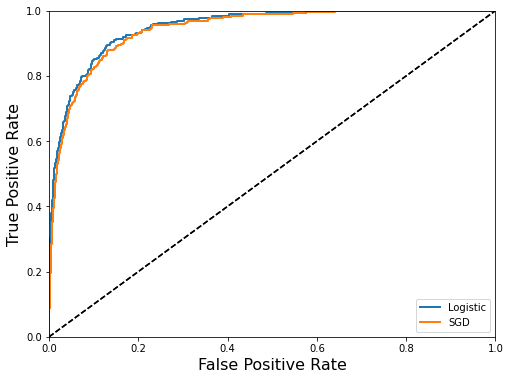

Logistic ROC AUC: 0.9501229983391307, SGD ROC AUC: 0.9433360557488014


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt 

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

# Logistic regression 
log_reg = LogisticRegression(C=np.inf, random_state=42, solver='lbfgs')
log_reg.fit(X_train, y_train.ravel())
log_y_scores = cross_val_predict(log_reg, X_train, y_train, cv=10, method='decision_function')
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, log_y_scores)
log_roc_auc = roc_auc_score(y_train, log_y_scores)

# SGD Classifier 
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train.ravel())
sgd_y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=10, method='decision_function')
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train, sgd_y_scores)
sgd_roc_auc = roc_auc_score(y_train, sgd_y_scores)

# plotting 
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_log, tpr_log, 'Logistic')
plot_roc_curve(fpr_sgd, tpr_sgd, 'SGD')
plt.legend(loc='lower right')
plt.show()

print(f'Logistic ROC AUC: {log_roc_auc}, SGD ROC AUC: {sgd_roc_auc}')


For these classifiers, plot the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 80%. Consider 4 models:
 1.  The logistic regression classifier,
 2. `SGDClassifier`,
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.
 
For each of the 4 models, determine the threshold to achieve an 80% recall based on 10-fold cross-validation. Then determine the corresponding precisions. 

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="lower left", fontsize=16)
    plt.ylim([0, 1])

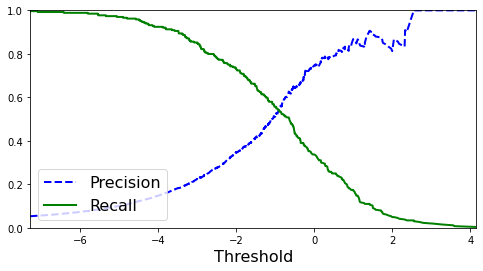

In [ ]:
# Logistic Regression 
log_precisions, log_recalls, log_thresholds = precision_recall_curve(y_train, log_y_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(log_precisions, log_recalls, log_thresholds)
plt.xlim([log_thresholds.min(), log_thresholds.max()])
plt.show()

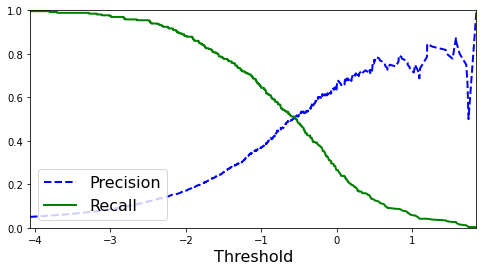

In [ ]:
# SGD Classifier 
sgd_precisions, sgd_recalls, sgd_thresholds = precision_recall_curve(y_train, sgd_y_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(sgd_precisions, sgd_recalls, sgd_thresholds)
plt.xlim([sgd_thresholds.min(), sgd_thresholds.max()])
plt.show()

Based on the precision values printed below, logistic regression had the best precision value of around 0.25029. 

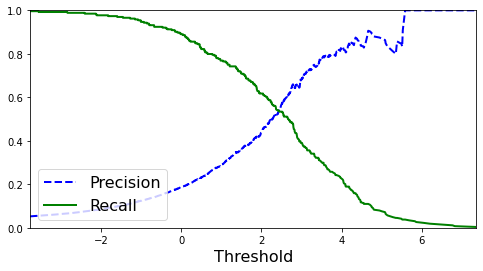

In [ ]:
# Logistic regression balanced 
log_reg_balanced = LogisticRegression(C=np.inf, random_state=42, solver='lbfgs', class_weight='balanced')
log_reg_balanced.fit(X_train, y_train.ravel())
log_y_scores_balanced = cross_val_predict(log_reg_balanced, X_train, y_train, cv=10, method='decision_function')
log_precisions_balanced, log_recalls_balanced, log_thresholds_balanced = precision_recall_curve(y_train, log_y_scores_balanced)

log_precisions_bal, log_recalls_bal, log_thresholds_bal = precision_recall_curve(y_train, log_y_scores_balanced)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(log_precisions_bal, log_recalls_bal, log_thresholds_bal)
plt.xlim([log_thresholds_bal.min(), log_thresholds_bal.max()])
plt.show()

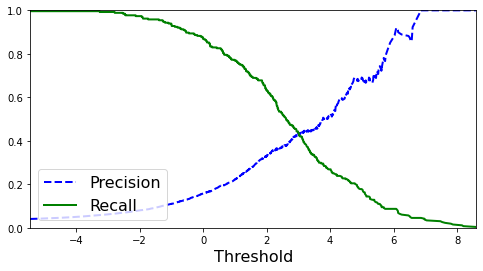

In [ ]:
# SGD classifier balanced 
sgd_clf_balanced = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42, class_weight='balanced')
sgd_clf_balanced.fit(X_train, y_train.ravel())
sgd_y_scores_balanced = cross_val_predict(sgd_clf_balanced, X_train, y_train, cv=10, method='decision_function')
sgd_precisions_balanced, sgd_recalls_balanced, sgd_thresholds_balanced = precision_recall_curve(y_train, sgd_y_scores_balanced)

sgd_precisions_bal, sgd_recalls_bal, sgd_thresholds_bal = precision_recall_curve(y_train, sgd_y_scores_balanced)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(sgd_precisions_bal, sgd_recalls_bal, sgd_thresholds_bal)
plt.xlim([sgd_thresholds_bal.min(), sgd_thresholds_bal.max()])
plt.show()

In [ ]:
# 80% recall 
def closest_value(ls, myNumber):
    # gets closest value to myNumber in a given list ls 
    return min(ls, key=lambda x:abs(x-myNumber))

def recall_idx(recalls, closest):
    # returns the first index of recalls where the closest value locates 
    return np.r_[np.where(np.array(recalls)==closest)[0][0]].flatten()[0]

log_closest = closest_value(log_recalls, 0.8)
sgd_closest = closest_value(sgd_recalls, 0.8)
log_closest_balanced = closest_value(log_recalls_balanced, 0.8)
sgd_closest_balanced = closest_value(sgd_recalls_balanced, 0.8)

log_recall80_idx = recall_idx(log_recalls, log_closest)
sgd_recall80_idx = recall_idx(sgd_recalls, sgd_closest)
log_recall80_balanced_idx = recall_idx(log_recalls_balanced, log_closest_balanced)
sgd_recall80_balanced_idx = recall_idx(sgd_recalls_balanced, sgd_closest_balanced)

log_threshold80, log_precision80 = log_thresholds[log_recall80_idx], log_precisions[log_recall80_idx]
sgd_threshold80, sgd_precision80 = sgd_thresholds[sgd_recall80_idx], sgd_precisions[sgd_recall80_idx]
log_threshold80_balanced, log_precision80_balanced = log_thresholds_balanced[log_recall80_balanced_idx], log_precisions_balanced[log_recall80_balanced_idx]
sgd_threshold80_balanced, sgd_precision80_balanced = sgd_thresholds_balanced[sgd_recall80_balanced_idx], sgd_precisions_balanced[sgd_recall80_balanced_idx]

print(f'THRESHOLDS: log: {log_threshold80}, sgd: {sgd_threshold80}, log_balanced: {log_threshold80_balanced}, sgd_balanced: {sgd_threshold80_balanced}')
print(f'PRECISIONS: log: {log_precision80}, sgd: {sgd_precision80}, log_balanced: {log_precision80_balanced}, sgd_balanced: {sgd_precision80_balanced}')


THRESHOLDS: log: -2.71491725068452, sgd: -1.5816012168956486, log_balanced: 0.6608221544985606, sgd_balanced: 0.6628204273686764
PRECISIONS: log: 0.25029655990510086, sgd: 0.2395005675368899, log_balanced: 0.24823529411764705, sgd_balanced: 0.19609665427509293


Fit the best classifier to the whole training data, and use it to predict on the test set. 

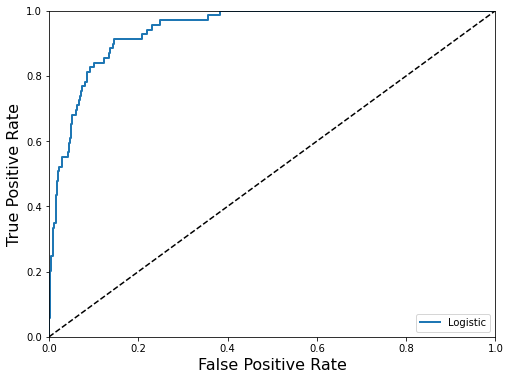

Accuracy: 96.95, precision: 0.6333333333333333, recall: 0.2753623188405797, ROC AUC: 0.9423667244575537


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Using the logistic regression model 
y_pred_test = log_reg.predict(X_test)

# accuracy, precision, recall 
n_correct = sum(y_test==y_pred_test)
accuracy_test = 100*n_correct/len(y_pred_test)
precision_test = precision_score(y_test, y_pred_test) # TP/(TP+FP)
recall_test = recall_score(y_test, y_pred_test) # TP/(TP+FN)

# ROC curve 
test_y_scores = cross_val_predict(log_reg, X_test, y_test, cv=10, method='decision_function')
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_y_scores)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_test, tpr_test, 'Logistic')
plt.legend(loc='lower right')
plt.show()

# ROC AUC 
test_roc_auc = roc_auc_score(y_test, test_y_scores)

print(f'Accuracy: {accuracy_test}, precision: {precision_test}, recall: {recall_test}, ROC AUC: {test_roc_auc}')
